In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Считываем данные из JSON файла в DataFrame
data = pd.read_json('/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
data = data.drop(['link', 'date'], axis=1)
data.head()

,headline,category,short_description,authors
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP"
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski


In [ ]:
data.describe()

,headline,category,short_description,authors
count,209527,209527,209527,209527
unique,207996,42,187022,29169
top,Sunday Roundup,POLITICS,,
freq,90,35602,19712,37418


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           209527 non-null  object
 1   category           209527 non-null  object
 2   short_description  209527 non-null  object
 3   authors            209527 non-null  object
dtypes: object(4)
memory usage: 6.4+ MB


In [ ]:
data['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [ ]:
data['category'] = data['category'].str.replace('THE WORLDPOST', 'WORLDPOST')
data['category'] = data['category'].str.replace('CULTURE & ARTS', 'ARTS')
data['category'] = data['category'].str.replace('ARTS & CULTURE', 'ARTS')

**Визуализация целевой переменной Category**

In [ ]:
category_counts = data['category'].value_counts()

plt.figure(figsize=(10, 8))
plt.title('Распределение категорий')

sns.countplot(y='category', data=data, order=category_counts.index, palette='Set1')
plt.xlabel('Количество записей')
plt.ylabel('Категория')
plt.show()

In [ ]:
for col in range(len(data.columns)):
    print(f'{data.columns[col]}: {data.iloc[2, col]}')

headline: 23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23)
category: COMEDY
short_description: "Until you have a dog you don't understand what could be eaten."
authors: Elyse Wanshel


**Распределение числа слов в заголовке новостей**

In [ ]:
def count_words(text):
    words = text.split()
    return len(words)

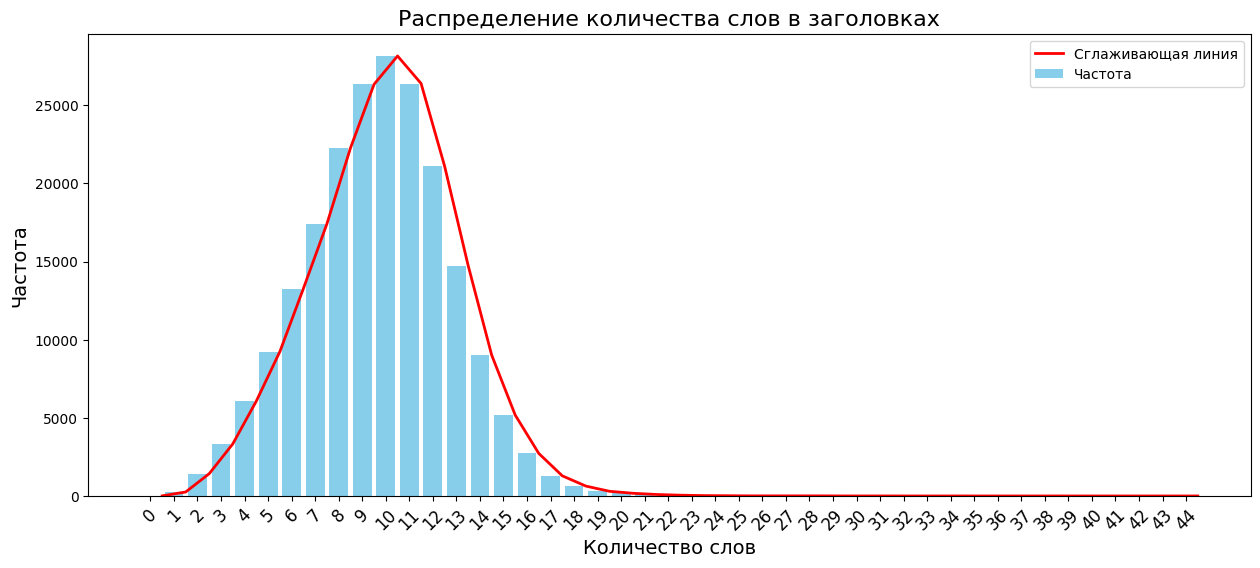

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Предположим, что у вас уже есть переменные data и функция count_words для подсчета слов

# Получаем количество слов в заголовках
headline_word_counts = data['headline'].apply(count_words)

# Определяем минимальное и максимальное количество слов
min_word_count = headline_word_counts.min()
max_word_count = headline_word_counts.max()

# Определяем бины с шагом 1 от минимального до максимального количества слов
bins = range(min_word_count, max_word_count + 2)  # +2, чтобы включить максимальное значение

# Делим количество слов на категории (бины)
word_count_bins = pd.cut(headline_word_counts, bins=bins, right=False, include_lowest=True)

# Подсчитываем количество элементов в каждой категории (бине)
count_by_bin = word_count_bins.value_counts().sort_index()

# Извлекаем границы бинов и метки бинов (используем числовые метки напрямую)
bin_labels = [str(i) for i in range(min_word_count, max_word_count + 1)]  # Метки в виде строк с числами

# Центры бинов для построения скользящей сглаживающей линии
bin_centers = [i + 0.5 for i in range(min_word_count, max_word_count + 1)]

# Создаем новый график
plt.figure(figsize=(15, 6))

# Строим столбчатую диаграмму с бинами
plt.bar(bin_labels, count_by_bin.values, color='skyblue', width=0.8, label='Частота')

# Строим скользящую сглаживающую линию
plt.plot(bin_centers, count_by_bin.values, color='red', linestyle='-', linewidth=2, label='Сглаживающая линия')

# Настройка заголовка и подписей осей
plt.title('Распределение количества слов в заголовках', fontsize=16)
plt.xlabel('Количество слов', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

# Добавляем легенду
plt.legend()

# Отображаем график
plt.show()


In [ ]:
max_length = data['headline'].apply(len).max()

# Найти первый заголовок с минимальной длиной
max_length_headline = data.loc[data['headline'].apply(len) == max_length, 'headline'].iloc[0]

# Вывести минимальную длину и соответствующий заголовок
print(f"Максимальная длина заголовка: {max_length} символов")
print(f"Заголовок с максимальной длиной: '{max_length_headline}'")

Максимальная длина заголовка: 320 символов
Заголовок с максимальной длиной: 'Wendy Williams Announces 12-City ‘Sit Down Tour’ Read more at http://www.eurweb.com/2015/07/wendy-williWendy Williams Announces 12-City ‘Sit Down Tour’ Read more at http://www.eurweb.com/2015/07/wggendy-williams-announces-12-city-sit-down-tour/#CzdwTvg7bx2ZhiMt.99ams-announces-12-city-sit-down-tour/#CzdwTvg7bx2ZhiMt.99'


**Распределение числа слов в описании новости**

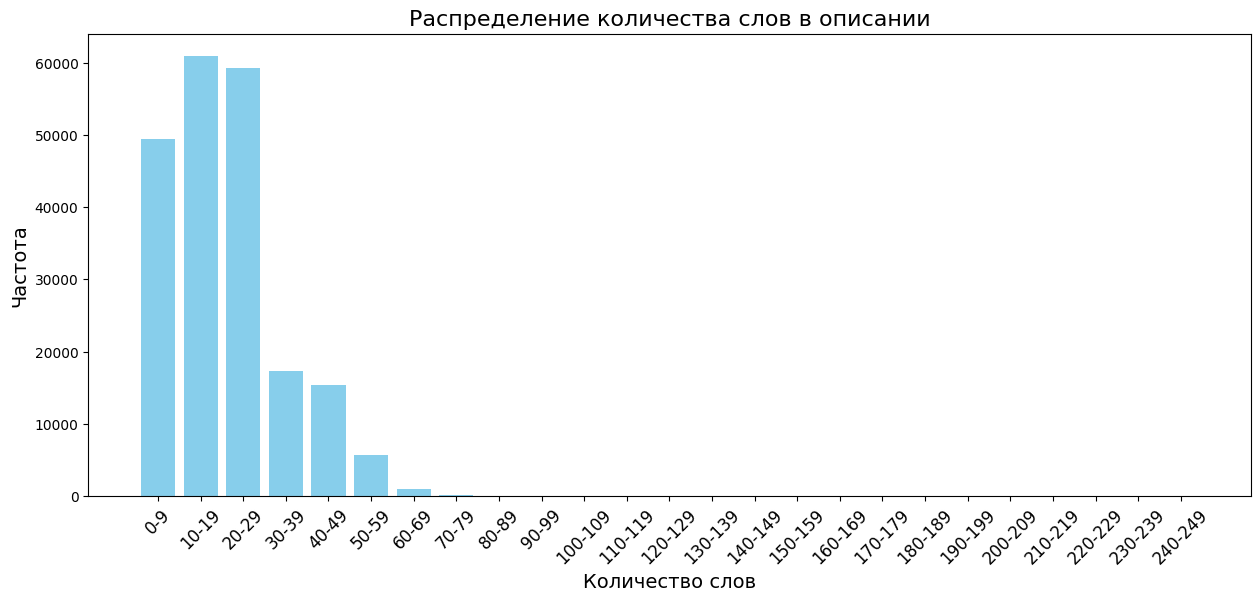

In [ ]:
short_description_word_counts = data['short_description'].apply(count_words)

# Determine the minimum and maximum word counts
min_word_count = short_description_word_counts.min()
max_word_count = short_description_word_counts.max()

# Define bins with a step of 100
bins = range(0, max_word_count + 10, 10)  # Bins with step of 100 (e.g., 0, 100, 200, ...)

# Bin the word counts into categories
word_count_bins = pd.cut(short_description_word_counts, bins=bins, right=False, include_lowest=True)

# Count occurrences of each word count category
count_by_bin = word_count_bins.value_counts().sort_index()

# Extract bin edges and bin labels
bin_labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# Plotting the bar chart with bins of size 100
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(bin_labels, count_by_bin.values, color='skyblue', width=0.8)  # Specify bar width for clearer bins

# Set titles and labels
plt.title('Распределение количества слов в описании', fontsize=16)  # Title
plt.xlabel('Количество слов', fontsize=14)  # X-axis label
plt.ylabel('Частота', fontsize=14)  # Y-axis label
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels and set font size

# Show the plot
plt.show()

In [ ]:
max_length = data['short_description'].apply(len).max()

max_length_descr = data.loc[data['short_description'].apply(len) == max_length, 'short_description'].iloc[0]

print(f"Максимальная длина новости: {max_length} символов")
print(f"Новость с максимальной длиной: '{max_length_descr}'")

Максимальная длина новости: 1472 символов
Новость с максимальной длиной: 'This week the nation watched as the #NeverTrump movement folded faster than one of the presumptive nominee's beachfront developments. As many tried to explain away Trump's reckless, racist extremism, a few put principle over party. The wife of former Republican Senator Bob Bennett, who died on May 4, revealed that her husband spent his dying hours reaching out to Muslims. "He would go to people with the hijab [on] and tell them he was glad they were in America," she told the Daily Beast. "He wanted to apologize on behalf of the Republican Party." In the U.K., Prime Minister David Cameron called Trump's proposal to ban Muslims from entering the U.S., "divisive, stupid and wrong." Trump's reply was that he didn't think he and Cameron would "have a very good relationship." The press is also doing its part to whitewash extremism. The New York Times called Trump's racism "a reductive approach to ethnicity," and said T

**Удаление ссылок из признаков**

In [ ]:
def remove_links(text):
    # Регулярное выражение для поиска ссылок
    link_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # Удаление ссылок из текста
    cleaned_text = re.sub(link_pattern, '', text)
    return cleaned_text

# Применение функции remove_links к столбцам 'headline' и 'short_description'
data['headline'] = data['headline'].apply(remove_links)
data['short_description'] = data['short_description'].apply(remove_links)

In [ ]:
from scipy.stats import chi2_contingency

cross_table = pd.crosstab(data['authors'], data['category'])

# Выполнение хи-квадрат теста
chi2, p_val, _, _ = chi2_contingency(cross_table)

# Вывод результатов теста
print("Хи-квадрат статистика:", chi2)
print("p-value:", p_val)

# Определение статистической значимости (обычно пороговое значение alpha = 0.05)
alpha = 0.05
if p_val < alpha:
    print("Есть статистически значимая зависимость между автором и жанром новости.")
else:
    print("Нет статистически значимой зависимости между автором и жанром новости.")

Хи-квадрат статистика: 4197845.997548305
p-value: 0.0
Есть статистически значимая зависимость между автором и жанром новости.


**Авторы, опубликовавшие больше всего новостей, и их публикации**

In [ ]:
top_authors = data['authors'].value_counts().nlargest(10)

# Вывод топ-10 авторов с количеством опубликованных новостей
print("Топ-10 популярных авторов:")
top_authors

Топ-10 популярных авторов:


authors
                    37418
Lee Moran            2954
Ron Dicker           2219
Ed Mazza             1590
Mary Papenfuss       1566
Reuters, Reuters     1563
Cole Delbyck         1266
Carly Ledbetter      1170
Curtis M. Wong       1146
Andy McDonald        1100
Name: count, dtype: int64

In [ ]:
top_authors = data['authors'].value_counts().nlargest(10).index

top_genres_by_author = {}

# Перебираем каждого из топ-10 авторов
for author in top_authors:
    # Фильтруем DataFrame для текущего автора
    author_data = data[data['authors'] == author]

    # Подсчитываем количество новостей каждого жанра для данного автора
    genre_counts = author_data['category'].value_counts().nlargest(4)

    # Преобразуем результат в словарь и сохраняем для текущего автора
    top_genres_by_author[author] = genre_counts.to_dict()

# Вывод результатов для каждого автора
for author, genre_counts in top_genres_by_author.items():
    print(f"Автор: {author}")
    for genre, count in genre_counts.items():
        print(f"Жанр: {genre}, Количество новостей: {count}")
    print()  # Пустая строка между авторами для разделения вывода

Автор: 
Жанр: WELLNESS, Количество новостей: 5000
Жанр: POLITICS, Количество новостей: 3626
Жанр: STYLE & BEAUTY, Количество новостей: 2527
Жанр: PARENTING, Количество новостей: 2270

Автор: Lee Moran
Жанр: COMEDY, Количество новостей: 841
Жанр: POLITICS, Количество новостей: 531
Жанр: ENTERTAINMENT, Количество новостей: 491
Жанр: WEIRD NEWS, Количество новостей: 393

Автор: Ron Dicker
Жанр: ENTERTAINMENT, Количество новостей: 658
Жанр: SPORTS, Количество новостей: 420
Жанр: COMEDY, Количество новостей: 414
Жанр: WEIRD NEWS, Количество новостей: 269

Автор: Ed Mazza
Жанр: POLITICS, Количество новостей: 347
Жанр: COMEDY, Количество новостей: 343
Жанр: MEDIA, Количество новостей: 224
Жанр: ENTERTAINMENT, Количество новостей: 219

Автор: Mary Papenfuss
Жанр: POLITICS, Количество новостей: 859
Жанр: COMEDY, Количество новостей: 129
Жанр: CRIME, Количество новостей: 76
Жанр: GREEN, Количество новостей: 76

Автор: Reuters, Reuters
Жанр: WELLNESS, Количество новостей: 642
Жанр: BUSINESS, Коли

In [ ]:
data['short_description'] = data['authors'] + ', ' + data['headline'] + ', ' + data['short_description']
data.head()

,headline,category,short_description,authors
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,"Carla K. Johnson, AP, Over 4 Million Americans...","Carla K. Johnson, AP"
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,"Mary Papenfuss, American Airlines Flyer Charge...",Mary Papenfuss
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"Elyse Wanshel, 23 Of The Funniest Tweets About...",Elyse Wanshel
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"Caroline Bologna, The Funniest Tweets From Par...",Caroline Bologna
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,"Nina Golgowski, Woman Who Called Cops On Black...",Nina Golgowski


In [ ]:
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])

data

,headline,category,short_description,authors
0,Over 4 Million Americans Roll Up Sleeves For O...,32,"Carla K. Johnson, AP, Over 4 Million Americans...","Carla K. Johnson, AP"
1,"American Airlines Flyer Charged, Banned For Li...",32,"Mary Papenfuss, American Airlines Flyer Charge...",Mary Papenfuss
2,23 Of The Funniest Tweets About Cats And Dogs ...,4,"Elyse Wanshel, 23 Of The Funniest Tweets About...",Elyse Wanshel
3,The Funniest Tweets From Parents This Week (Se...,20,"Caroline Bologna, The Funniest Tweets From Par...",Caroline Bologna
4,Woman Who Called Cops On Black Bird-Watcher Lo...,32,"Nina Golgowski, Woman Who Called Cops On Black...",Nina Golgowski
...,...,...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,30,"Reuters, Reuters, RIM CEO Thorsten Heins' 'Sig...","Reuters, Reuters"
209523,Maria Sharapova Stunned By Victoria Azarenka I...,26,", Maria Sharapova Stunned By Victoria Azarenka...",
209524,"Giants Over Patriots, Jets Over Colts Among M...",26,", Giants Over Patriots, Jets Over Colts Among ...",
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,26,", Aldon Smith Arrested: 49ers Linebacker Buste...",


**Векторизация текста с помощью BERT**

In [ ]:
X = data['short_description']
y = data['category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', device=device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_text(text):
    # Токенизация текста и добавление специальных токенов
    tokens = tokenizer.encode_plus(text, max_length=64, truncation=True,
                                    padding='max_length', add_special_tokens=True,
                                    return_tensors='pt')
    # Перемещение тензоров на GPU (если доступен)
    tokens = {key: val.to(device) for key, val in tokens.items()}
    return tokens

In [ ]:
# Преобразование X_train и X_test в числовые токены
X_train = [tokenize_text(text) for text in X_train]
X_test = [tokenize_text(text) for text in X_test]

In [ ]:
len(data.iloc[0, 2].split())

44

In [ ]:
X_train[0]

{'input_ids': tensor([[  101,  2984,  6643, 11837, 25608,  2015,  1010,  5608,  6848,  9268,
           8398,  1005,  1055,  2171,  2013,  7128,  2152, 29346,  1024,  3189,
           1010,  1996,  2311,  1005,  1055,  3901,  2024,  2893, 10147, 12079,
           2100,  2055,  4359,  5300,  1999,  5144,  5799,  2000,  1996,  3807,
           1011, 17727,  5243,  7690,  2280,  2343,  1012,   102,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       

In [ ]:
input_ids = torch.cat([sample['input_ids'] for sample in X_train], dim=0)
attention_masks = torch.cat([sample['attention_mask'] for sample in X_train], dim=0)
labels_train = torch.tensor(y_train.values)
labels_test = torch.tensor(y_test.values)

In [ ]:
# Создание TensorDataset из токенизированных данных и меток классов
train_dataset = TensorDataset(torch.stack([sample['input_ids'] for sample in X_train]),
                              torch.stack([sample['attention_mask'] for sample in X_train]),
                              labels_train)

test_dataset = TensorDataset(torch.stack([sample['input_ids'] for sample in X_test]),
                             torch.stack([sample['attention_mask'] for sample in X_test]),
                             labels_test)

# Определение размера пакета (batch_size) и создание DataLoader
batch_size = 128  # Размер пакета для обучения и тестирования

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Построение модели

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Создание модели классификации на основе BERT-large
class BertLargeClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertLargeClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Передаем input_ids и attention_mask как именованные аргументы в self.bert
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
num_classes = len(set(y_train))  # Количество классов (зависит от вашей задачи классификации)

num_classes

39

In [ ]:
model = BertLargeClassifier(bert_model, num_classes)
model.to(device)

BertLargeClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 109512231


In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [ ]:
# Функция обучения модели
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        input_ids = batch[0].squeeze().to(device)           # Извлечение input_ids из пакета
        attention_mask = batch[1].squeeze().to(device)      # Извлечение attention_mask из пакета
        labels = batch[2].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

# Функция тестирования модели
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].squeeze().to(device)           # Извлечение input_ids из пакета
            attention_mask = batch[1].squeeze().to(device)      # Извлечение attention_mask из пакета
            labels = batch[2].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

In [ ]:
# Обучение и тестирование модели
num_epochs = 3
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/3, Train Loss: 1.2276, Train Acc: 0.6844, Test Loss: 0.7416, Test Acc: 0.7897
Epoch 2/3, Train Loss: 0.6440, Train Acc: 0.8145, Test Loss: 0.6495, Test Acc: 0.8089
Epoch 3/3, Train Loss: 0.4840, Train Acc: 0.8572, Test Loss: 0.6405, Test Acc: 0.8135


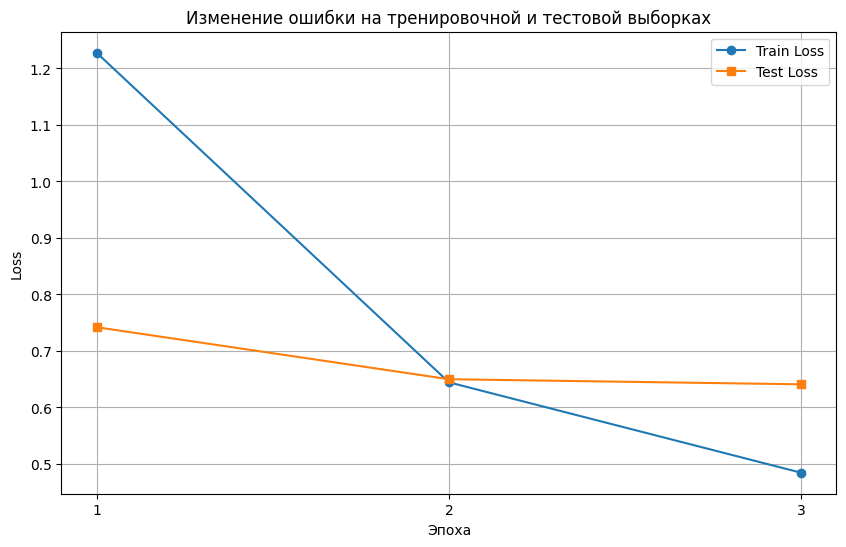

In [ ]:
epochs = range(1, len(train_losses) + 1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='s')
plt.title('Изменение ошибки на тренировочной и тестовой выборках')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

**Финальное тестирование модели**

In [ ]:
def evaluate_metrics(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].squeeze().to(device)           # Извлечение input_ids из пакета
            attention_mask = batch[1].squeeze().to(device)      # Извлечение attention_mask из пакета
            labels = batch[2].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    avg_loss = total_loss / len(test_loader)

    metrics_dict = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Average Loss': avg_loss
    }

    metrics_df = pd.DataFrame(metrics_dict, index=[0])
    return metrics_df, y_pred

# Пример использования
metrics_df, y_pred = evaluate_metrics(model, test_loader, criterion, device)
metrics_df

,Accuracy,Precision,Recall,F1-Score,Average Loss
0,0.813487,0.747464,0.751986,0.748236,0.640519


In [ ]:
df_true_pred = y_test.to_frame(name='true')
df_true_pred['predict'] = y_pred
df_true_pred.head()

,true,predict
128310,16,21
139983,2,2
42339,22,22
131494,13,13
163649,25,25


In [ ]:
df_true_pred = df_true_pred.merge(data['short_description'], how='left', left_index=True, right_index=True)
df_true_pred = df_true_pred[['short_description', 'true', 'predict']]
df_true_pred.head()

,short_description,true,predict
128310,"Matt Murrie, ContributorEdupreneur, Cofounder/...",16,21
139983,", Firestorm At AOL Over Employee Benefit Cuts,...",2,2
42339,"Michael McLaughlin & Josh Morgan, The Huffingt...",22,22
131494,", One Glimpse Of These Baby Kit Foxes And You'...",13,13
163649,"Melissa Cronin, Mens' Sweat Pheromone, Androst...",25,25


In [ ]:
df_true_pred['true'] = label_encoder.inverse_transform(df_true_pred['true'])
df_true_pred['predict'] = label_encoder.inverse_transform(df_true_pred['predict'])

df_true_pred[:20]

,short_description,true,predict
128310,"Matt Murrie, ContributorEdupreneur, Cofounder/...",IMPACT,PARENTS
139983,", Firestorm At AOL Over Employee Benefit Cuts,...",BUSINESS,BUSINESS
42339,"Michael McLaughlin & Josh Morgan, The Huffingt...",POLITICS,POLITICS
131494,", One Glimpse Of These Baby Kit Foxes And You'...",GREEN,GREEN
163649,"Melissa Cronin, Mens' Sweat Pheromone, Androst...",SCIENCE,SCIENCE
192926,"Marva Soogrim, Contributor\nMarvalous Babies, ...",PARENTING,PARENTING
183417,"Jason W. Womack, Contributor\nAuthor, Advisor,...",WELLNESS,WELLNESS
35735,"University of Central Florida Forum, Contribut...",SCIENCE,COLLEGE
139757,"Chanel Parks, Supermodel Stephanie Seymour Doe...",STYLE & BEAUTY,STYLE & BEAUTY
29057,"Mike Weisser, ContributorMike the Gun Guy, Ame...",POLITICS,POLITICS


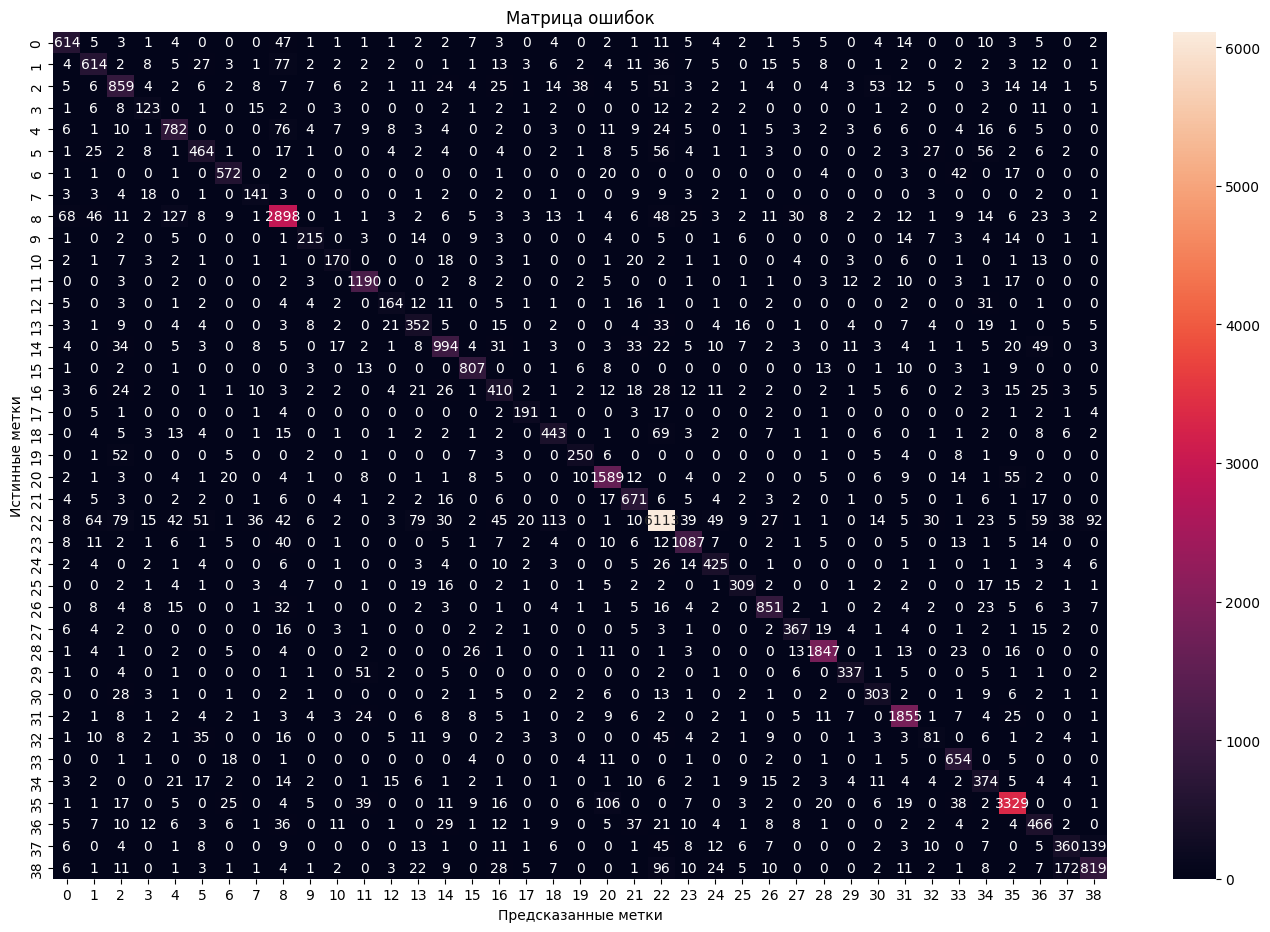

In [ ]:
# Получение уникальных классов из y_test (все возможные метки)
unique_classes = np.unique(np.concatenate([y_test.values, y_pred]))

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)

# Создание DataFrame из матрицы ошибок
cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

# Построение тепловой карты (heatmap) с помощью seaborn
plt.figure(figsize=(17, 11))
sns.heatmap(cm_df, annot=True, cbar=True, fmt='g')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show();